# Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#now mount to drive and set the working directory to our shared drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
concatenated_path = '/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/all_data/'

In [4]:
os.chdir(concatenated_path)

# Read in yield data

In [40]:
yield_path = '/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/all_data/yields/'
os.chdir(yield_path)

In [41]:
files = dict.fromkeys(os.listdir(), None)
files

{'maize.csv': None, 'maize_major.csv': None, 'maize_second.csv': None}

In [42]:
maize = pd.read_csv(yield_path + 'maize.csv', index_col = 0)
maize_major = pd.read_csv(yield_path + 'maize_major.csv', index_col = 0)
maize_second = pd.read_csv(yield_path + 'maize_second.csv', index_col = 0)

In [43]:
maize_csvs = [maize, maize_major, maize_second]

In [44]:
np.sort(maize['year'].unique())

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016])

In [45]:
len(maize['year'].unique())

36

# Read in climate data

In [5]:
climate_path = '/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/all_data/climate/'
os.chdir(climate_path)

In [6]:
files = dict.fromkeys(os.listdir(), None)
files

{'historical': None, 'ssp126': None, 'ssp370': None, 'ssp585': None}

In [7]:
historical = pd.read_csv(climate_path + 'historical/historical_all_variables.csv', index_col = 0)
ssp126 = pd.read_csv(climate_path + 'ssp126/ssp126_all_variables.csv', index_col = 0)
ssp370 = pd.read_csv(climate_path + 'ssp370/ssp370_all_variables.csv', index_col = 0)
ssp585 = pd.read_csv(climate_path + 'ssp585/ssp585_all_variables.csv', index_col = 0)

In [8]:
variables = ['pr', 'huss', 'hurs', 'ps', 'tas', 'sfcwind', 'rlds', 'rsds',
       'tasmin', 'tasmax']
scenarios_csvs = [historical, ssp126, ssp370, ssp585]
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

In [9]:
historical[historical['variable'] == 'huss']['value'].isna().sum()

0

# Class for grouping climate data

In [10]:
class subset_aggregation():
  def __init__(self, df):
    self.df = df 
    self.variables = ['pr', 'huss', 'hurs', 'ps', 'tas', 'sfcwind', 'rlds', 'rsds','tasmin', 'tasmax']
    self.scenario_dict = None
    self.years = ['1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']

  def make_dict_with_subset(self):
    scenario_dict = dict.fromkeys(self.variables)
    for variable in self.variables:
      scenario_dict[variable] = {}
      scenario_dict[variable]['subset'] = self.df[self.df['variable'] == variable].reset_index(drop = True)
    self.scenario_dict = scenario_dict

  def split_date(self):
    for variable in self.variables:
      df = self.scenario_dict[variable]['subset']
      df['year'] = [x[0:4] for x in df['time']]
      df['month'] = [x[5:7] for x in df['time']]
      df.drop('time', axis=1)
      self.scenario_dict[variable]['subset'] = df
  
  def growing_months_subset(self): 
    growing_months = ['11', '12', '01', '02', '03', '04']
    for variable in self.variables:
      df = self.scenario_dict[variable]['subset']
      df = df[df['month'].isin(growing_months)]
      self.scenario_dict[variable]['subset'] = df

  def growing_months_allocation(self):
    test = self.scenario_dict['huss']['subset']
    months_years = set()
    for x, y in test[['year', 'month']].itertuples(index=False):
      months_years.add((x, y))
    months_years = list(months_years)
    growing_seasons = pd.DataFrame(columns = ['year', 'month'])
    for combo in range(0, len(months_years)):
      growing_seasons.at[combo, 'year'] = months_years[combo][0]
      growing_seasons.at[combo, 'month'] = months_years[combo][1]
    growing_seasons = growing_seasons.sort_values(['year', 'month']).reset_index(drop = True)
    growing_seasons = growing_seasons.drop(growing_seasons.head(4).index, axis=0) #drop the first 4 months of 1981 since it has no assigned growing season
    growing_seasons = growing_seasons.drop(growing_seasons.tail(2).index, axis = 0) #drop the last 2 months of 2014 since it has no assigned growing season
    seasons = []
    for season in range(1, (int((len(growing_seasons)/6))+1)):
      seasons.append([season] * 6)
    seasons = [item for sublist in seasons for item in sublist]
    growing_seasons['growing_season'] = seasons
    for variable in self.variables:
      df = self.scenario_dict[variable]['subset']
      df = df.merge(growing_seasons, how = 'left', on = ['year', 'month'])
      self.scenario_dict[variable]['subset'] = df
      

        #df.loc[mask, 'growing_season'] = [season_count if x == year_1 and y in late_months or x == year_2 and y in early_months else 'Not growing season' for x, y in df.loc[mask, ['year', 'month']].itertuples(index=False)]

        #df.loc[mask, 'growing_season'] = [season_count if x == year_1 and y in late_months else season_count if x == year_2 and y in early_months else 'Not growing season' for x, y in df.loc[mask, ['year', 'month']].itertuples(index=False)]
        #df.loc[mask, 'growing_season'] = [season_count if (x == year_2 and y in early_months) and df.loc[mask,'growing_season'] != 'Not growing season' else 'Not growing season' for x, y in df.loc[mask, ['year', 'month']].itertuples(index=False)]
        
        #mask1 = df[df['year'].isin([year_1])].index
        #df.loc[mask1, 'growing_season'] = [season_count if x in late_months else 'Not growing season' for x in df.loc[mask1, ['month']]]
        #mask2 = df[df['year'].isin([year_2])].index
        #df.loc[mask2, 'growing_season'] = [season_count if y in early_months else 'Not growing season' for y in df.loc[mask2, ['year', 'month']]]

        #mask_1 = df[df['year'].isin([year_1]) & df['month'].isin([late_months])].index
        #df.loc[mask_1, 'growing_season'] = season_count
        #mask_2 = df[df['year'].isin([year_2]) & df['month'].isin([early_months])].index
        #df.loc[mask_2, 'growing_season'] = season_count
        #season_count += 1
  def gdd_calc(self):
    temp_min = 294.15 #data is in kelvin, this is equivalent to 21 degrees C
    temp_max = 300.15 #data is in kelvin, this is equivalent to 27 degrees C
    df = self.scenario_dict['tas']['subset']
    df['gdd'] = [0 if (x > temp_max or x < temp_min) else 1 for x in df['value']]
  
  def tas_agg(self, variable):
    #df = self.scenario_dict['tas']['subset']
    #df = df.groupby(['lat', 'lon', 'growing_season']).agg({'value': [np.min, percentile(25), percentile(50), percentile(75), np.max], 'gdd': 'count'})#lambda x: np.percentile(x['value'], q = 25))
    #self.scenario_dict[variable]['group_by'] = df
    df = self.scenario_dict['tas']['subset']
    df = df.groupby(['lat', 'lon', 'growing_season'], as_index = False).agg({'value': [np.min, percentile(25), percentile(50), percentile(75), np.max], 'gdd': ['sum'], 'scenario': ['first']})#lambda x: np.percentile(x['value'], q = 25))
    prefix = variable + '_' 
    df.columns = ['lat', 'lon', 'growing_season', prefix + 'min', prefix + 'percentile_25', prefix + 'percentile_50', prefix + 'percentile_75', prefix + 'max', prefix + 'gdd', 'scenario']
    self.scenario_dict['tas']['group_by'] = df

  def groupby_agg(self, variables, aggregation: str):
    for variable in variables:
      df = self.scenario_dict[variable]['subset']
      df = df.groupby(['lat', 'lon', 'growing_season'], as_index = False).agg({'value': [np.min, percentile(25), percentile(50), percentile(75), np.max], 'scenario': ['first']})
      prefix = variable + '_' 
      df.columns = ['lat', 'lon',  'growing_season',  prefix + 'min',  prefix + 'percentile_25',  prefix + 'percentile_50',  prefix + 'percentile_75',  prefix + 'max', 'scenario']
      self.scenario_dict[variable]['group_by'] = df



#to get percentiles https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function


In [11]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Test aggregation on historical

## Clean subset and assign growing seasons

In [12]:
#instantiate class with a scenario dataset 
historical_clean = subset_aggregation(historical)

In [13]:
#below makes a dictionary where each key is a variable
historical_clean.make_dict_with_subset()

In [14]:
historical_clean.scenario_dict.keys()

dict_keys(['pr', 'huss', 'hurs', 'ps', 'tas', 'sfcwind', 'rlds', 'rsds', 'tasmin', 'tasmax'])

In [15]:
#below splits the date into a workable format for each variable
historical_clean.split_date()

In [16]:
historical_clean.scenario_dict['hurs'].keys()

dict_keys(['subset'])

In [17]:
#below subsets the data to only include November, December, January, February, March and April i.e. growing season
historical_clean.growing_months_subset()
historical_clean.scenario_dict['huss']['subset']['month'].unique()

array(['01', '02', '03', '04', '11', '12'], dtype=object)

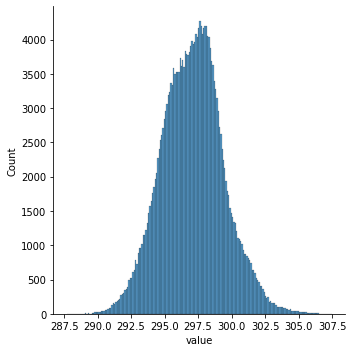

In [18]:
#observe distribution of temperature
sns.displot(historical_clean.scenario_dict['tas']['subset']['value'], kind = 'hist') #let's add a vertical line for min/max of GDD here

In [19]:
#below calculates gives a 1 to gdd if temperature in range, 0 otherwise
historical_clean.gdd_calc()

In [20]:
#below allocates growing seasons
historical_clean.growing_months_allocation()

## Group by

In [50]:
test = historical_clean.scenario_dict['tas']['subset'].sort_values(['year', 'month'])
test['growing_season'].unique()
test[(test['growing_season']==1)]

,time,lat,lon,value,variable,scenario,year,month,gdd,growing_season
174330,1981-11-01,-9.75,33.75,301.39008,tas,historical,1981,11,0,1.0
174331,1981-11-01,-9.75,34.25,296.50876,tas,historical,1981,11,1,1.0
174332,1981-11-01,-10.25,33.75,298.37305,tas,historical,1981,11,1,1.0
174333,1981-11-01,-10.25,34.25,300.56625,tas,historical,1981,11,0,1.0
174334,1981-11-01,-10.75,33.75,295.29855,tas,historical,1981,11,1,1.0
...,...,...,...,...,...,...,...,...,...,...
181384,1982-04-30,-15.75,35.25,295.01190,tas,historical,1982,04,1,1.0
181385,1982-04-30,-15.75,35.75,293.87698,tas,historical,1982,04,0,1.0
181386,1982-04-30,-16.25,34.75,299.12302,tas,historical,1982,04,1,1.0
181387,1982-04-30,-16.25,35.25,297.77887,tas,historical,1982,04,1,1.0


In [31]:
#group by for tas - specific function because of gdd
historical_clean.tas_agg('tas')

In [32]:
historical_clean.scenario_dict['tas']['group_by']

,lat,lon,growing_season,tas_min,tas_percentile_25,tas_percentile_50,tas_percentile_75,tas_max,tas_gdd,scenario
0,-16.75,35.25,1.0,295.50153,299.301670,300.49610,302.050500,304.88358,81,historical
1,-16.75,35.25,2.0,295.35830,299.618800,300.50018,301.645450,305.53864,67,historical
2,-16.75,35.25,3.0,294.93295,299.462640,300.56630,301.855087,305.71930,72,historical
3,-16.75,35.25,4.0,294.13257,298.771030,299.65237,300.872440,305.29350,115,historical
4,-16.75,35.25,5.0,295.00580,299.265720,300.28058,301.212460,306.23843,84,historical
...,...,...,...,...,...,...,...,...,...,...
1282,-9.75,34.25,29.0,292.07153,293.926970,294.73538,295.625030,298.39148,122,historical
1283,-9.75,34.25,30.0,291.64590,293.635530,294.22626,295.047670,297.62476,98,historical
1284,-9.75,34.25,31.0,292.15442,293.786958,294.41542,295.499000,298.41556,113,historical
1285,-9.75,34.25,32.0,292.93710,294.312100,295.26785,296.010740,298.96040,144,historical


In [33]:
#group by for all other variables
variables = ['pr', 'huss', 'hurs', 'ps', 'sfcwind', 'rlds', 'rsds','tasmin', 'tasmax']
historical_clean.groupby_agg(variables, 'group_by')

In [34]:
historical_clean.scenario_dict['ps']['group_by']

,lat,lon,growing_season,ps_min,ps_percentile_25,ps_percentile_50,ps_percentile_75,ps_max,scenario
0,-16.75,35.25,1.0,98775.445,99239.8700,99372.195,99584.090,99996.875,historical
1,-16.75,35.25,2.0,98695.730,99139.7500,99263.230,99428.040,99974.164,historical
2,-16.75,35.25,3.0,98531.700,99086.1975,99283.078,99485.541,100236.960,historical
3,-16.75,35.25,4.0,98650.210,99121.2600,99329.070,99478.010,99925.750,historical
4,-16.75,35.25,5.0,98757.140,99109.9500,99255.920,99436.586,100085.190,historical
...,...,...,...,...,...,...,...,...,...
1282,-9.75,34.25,29.0,94341.990,94595.9450,94678.160,94789.484,95039.920,historical
1283,-9.75,34.25,30.0,94344.010,94554.1300,94645.430,94758.620,95030.820,historical
1284,-9.75,34.25,31.0,94267.330,94592.3555,94695.875,94830.510,95024.766,historical
1285,-9.75,34.25,32.0,94480.016,94701.3100,94788.670,94873.945,95110.310,historical


# Run aggregation for all scenarios

# Scenarios

In [35]:
#instantiate class with a scenario dataset 
historical = subset_aggregation(historical)
#below makes a dictionary where each key is a variable
historical.make_dict_with_subset()
#below splits the date into a workable format for each variable
historical.split_date()
#below subsets the data to only include November, December, January, February, March and April i.e. growing season
historical.growing_months_subset()
#below calculates gives a 1 to gdd if temperature in range, 0 otherwise
historical.gdd_calc()
#below allocates growing seasons
historical.growing_months_allocation()
#group by for tas - specific function because of gdd
historical.tas_agg('tas')
#group by for all other variables
variables = ['pr', 'huss', 'hurs', 'ps', 'sfcwind', 'rlds', 'rsds','tasmin', 'tasmax']
historical.groupby_agg(variables, 'group_by')

## ssp126

In [36]:
#instantiate class with a scenario dataset 
ssp126 = subset_aggregation(ssp126)
#below makes a dictionary where each key is a variable
ssp126.make_dict_with_subset()
#below splits the date into a workable format for each variable
ssp126.split_date()
#below subsets the data to only include November, December, January, February, March and April i.e. growing season
ssp126.growing_months_subset()
#below calculates gives a 1 to gdd if temperature in range, 0 otherwise
ssp126.gdd_calc()
#below allocates growing seasons
ssp126.growing_months_allocation()
#group by for tas - specific function because of gdd
ssp126.tas_agg('tas')
#group by for all other variables
variables = ['pr', 'huss', 'hurs', 'ps', 'sfcwind', 'rlds', 'rsds','tasmin', 'tasmax']
ssp126.groupby_agg(variables, 'group_by')

## ssp370

In [37]:
#instantiate class with a scenario dataset 
ssp370 = subset_aggregation(ssp370)
#below makes a dictionary where each key is a variable
ssp370.make_dict_with_subset()
#below splits the date into a workable format for each variable
ssp370.split_date()
#below subsets the data to only include November, December, January, February, March and April i.e. growing season
ssp370.growing_months_subset()
#below calculates gives a 1 to gdd if temperature in range, 0 otherwise
ssp370.gdd_calc()
#below allocates growing seasons
ssp370.growing_months_allocation()
#group by for tas - specific function because of gdd
ssp370.tas_agg('tas')
#group by for all other variables
variables = ['pr', 'huss', 'hurs', 'ps', 'sfcwind', 'rlds', 'rsds','tasmin', 'tasmax']
ssp370.groupby_agg(variables, 'group_by')

## ssp585

In [38]:
#instantiate class with a scenario dataset 
ssp585 = subset_aggregation(ssp585)
#below makes a dictionary where each key is a variable
ssp585.make_dict_with_subset()
#below splits the date into a workable format for each variable
ssp585.split_date()
#below subsets the data to only include November, December, January, February, March and April i.e. growing season
ssp585.growing_months_subset()
#below calculates gives a 1 to gdd if temperature in range, 0 otherwise
ssp585.gdd_calc()
#below allocates growing seasons
ssp585.growing_months_allocation()
#group by for tas - specific function because of gdd
ssp585.tas_agg('tas')
#group by for all other variables
variables = ['pr', 'huss', 'hurs', 'ps', 'sfcwind', 'rlds', 'rsds','tasmin', 'tasmax']
ssp585.groupby_agg(variables, 'group_by')

# Final outputs

In [39]:
historical.scenario_dict['tas']['group_by']

,lat,lon,growing_season,tas_min,tas_percentile_25,tas_percentile_50,tas_percentile_75,tas_max,tas_gdd,scenario
0,-16.75,35.25,1.0,295.50153,299.301670,300.49610,302.050500,304.88358,81,historical
1,-16.75,35.25,2.0,295.35830,299.618800,300.50018,301.645450,305.53864,67,historical
2,-16.75,35.25,3.0,294.93295,299.462640,300.56630,301.855087,305.71930,72,historical
3,-16.75,35.25,4.0,294.13257,298.771030,299.65237,300.872440,305.29350,115,historical
4,-16.75,35.25,5.0,295.00580,299.265720,300.28058,301.212460,306.23843,84,historical
...,...,...,...,...,...,...,...,...,...,...
1282,-9.75,34.25,29.0,292.07153,293.926970,294.73538,295.625030,298.39148,122,historical
1283,-9.75,34.25,30.0,291.64590,293.635530,294.22626,295.047670,297.62476,98,historical
1284,-9.75,34.25,31.0,292.15442,293.786958,294.41542,295.499000,298.41556,113,historical
1285,-9.75,34.25,32.0,292.93710,294.312100,295.26785,296.010740,298.96040,144,historical


In [40]:
ssp126.scenario_dict['hurs']['group_by'] #because noticed fewer observations earler

,lat,lon,growing_season,hurs_min,hurs_percentile_25,hurs_percentile_50,hurs_percentile_75,hurs_max,scenario
0,-16.75,35.25,1.0,40.179554,65.092727,75.345712,82.992149,94.395890,ssp126
1,-16.75,35.25,2.0,37.684395,61.745537,70.164276,80.047050,95.602554,ssp126
2,-16.75,35.25,3.0,40.526160,69.690980,76.473480,83.194580,95.357910,ssp126
3,-16.75,35.25,4.0,44.763820,69.000950,75.777540,80.220820,95.414310,ssp126
4,-16.75,35.25,5.0,31.459028,67.154340,76.374755,83.296918,96.435780,ssp126
...,...,...,...,...,...,...,...,...,...
2959,-9.75,34.25,81.0,61.344555,72.895070,80.736370,83.599638,89.119230,ssp126
2960,-9.75,34.25,82.0,59.689117,77.399590,80.528790,83.232580,90.445170,ssp126
2961,-9.75,34.25,83.0,61.185772,73.775730,80.560295,83.537810,89.188805,ssp126
2962,-9.75,34.25,84.0,51.058650,69.147860,78.283570,82.457290,88.689030,ssp126


In [41]:
ssp370.scenario_dict['hurs']['group_by']

,lat,lon,growing_season,hurs_min,hurs_percentile_25,hurs_percentile_50,hurs_percentile_75,hurs_max,scenario
0,-16.75,35.25,1.0,37.277767,68.925287,76.639915,83.226408,92.681694,ssp370
1,-16.75,35.25,2.0,44.757614,63.128746,72.011390,79.112660,97.007970,ssp370
2,-16.75,35.25,3.0,41.147736,68.856440,77.447655,82.672930,93.606110,ssp370
3,-16.75,35.25,4.0,37.652977,55.910800,65.553040,78.399380,93.920220,ssp370
4,-16.75,35.25,5.0,41.440010,62.659416,70.814930,78.557095,94.037680,ssp370
...,...,...,...,...,...,...,...,...,...
3310,-9.75,34.25,81.0,53.840847,75.154043,80.053695,82.766370,87.086080,ssp370
3311,-9.75,34.25,82.0,55.835410,73.827835,78.252610,80.556320,87.646570,ssp370
3312,-9.75,34.25,83.0,53.235570,71.935720,78.520060,82.101105,87.840730,ssp370
3313,-9.75,34.25,84.0,54.644410,67.881294,75.050896,81.174210,86.717186,ssp370


In [42]:
#play around with the variable if you like
ssp585.scenario_dict['tas']['group_by']

,lat,lon,growing_season,tas_min,tas_percentile_25,tas_percentile_50,tas_percentile_75,tas_max,tas_gdd,scenario
0,-16.75,35.25,1.0,294.77795,299.210580,300.64009,302.021875,306.70566,75,ssp585
1,-16.75,35.25,2.0,297.28076,299.827900,301.38055,302.483800,306.00195,53,ssp585
2,-16.75,35.25,3.0,296.14355,299.582860,301.00540,301.789800,305.24040,59,ssp585
3,-16.75,35.25,4.0,297.01147,299.911400,301.05118,302.399050,306.06586,52,ssp585
4,-16.75,35.25,5.0,296.05380,298.930945,300.20120,301.237732,305.26007,90,ssp585
...,...,...,...,...,...,...,...,...,...,...
3310,-9.75,34.25,81.0,294.77524,297.923510,299.37239,300.514683,302.73044,124,ssp585
3311,-9.75,34.25,82.0,294.71160,296.983730,297.81670,298.944500,302.18920,156,ssp585
3312,-9.75,34.25,83.0,294.71985,297.231020,298.24106,299.905180,302.34186,141,ssp585
3313,-9.75,34.25,84.0,295.54780,298.021450,298.79370,299.756500,301.93192,148,ssp585


In [43]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
scenarios_data = [historical, ssp126, ssp370, ssp585]
variables = ['tas', 'pr', 'huss', 'hurs', 'ps', 'sfcwind', 'rlds', 'rsds', 'tasmin', 'tasmax']
path = '/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/'

In [44]:
count = 0 #start counter of scenarios for indexing
for scenario_data in scenarios_data: #iterate over all the subsetted and grouped by scenario data
  #print(scenario_data)
  scenario = scenarios[count] #index list of scenarios because they are strings and we can use to for indexing/path
  scenario_data = scenarios_data[count]
  #print(scenario_data)
  #print(scenario)
  new_count = 0
  for variable in variables:
   # print(variable)
    df = scenario_data.scenario_dict[variable]['group_by']
    print(scenarios[count])
    new_path = path + scenarios[count] + '/' + scenarios[count] + '_' + variables[new_count] +'.csv'
    print(new_path)
    df.to_csv(new_path, index_label = False)
    new_count +=1
  count += 1
  

historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/historical/historical_tas.csv
historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/historical/historical_pr.csv
historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/historical/historical_huss.csv
historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/historical/historical_hurs.csv
historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/historical/historical_ps.csv
historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/historical/historical_sfcwind.csv
historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_subset_groupby/historical/historical_rlds.csv
historical
/content/drive/Shareddrives/Spatial_Term_Paper/data/preprocessing/climate_